Decided to switch to Classification problem and split number of teams into two categories: Playoff Team/Non-Playoff Team where 10 wins and above is classified as a playoff team

In [40]:
import pandas as pd
import numpy as np
import time
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# 2017 data
data_2017 = pd.read_csv("2017_data.txt")
NFC_2017 = pd.read_csv("NFC_2017.txt")
AFC_2017 = pd.read_csv("AFC_2017.txt")

# 2018 data
data_2018 = pd.read_csv("2018_data.txt")
NFC_2018 = pd.read_csv("NFC_2018.txt")
AFC_2018 = pd.read_csv("AFC_2018.txt")

# 2019 data
data_2019 = pd.read_csv("2019_data.txt")
NFC_2019 = pd.read_csv("NFC_2019.txt")
AFC_2019 = pd.read_csv("AFC_2019.txt")

# 2020 data
data_2020 = pd.read_csv("2020_data.txt")
NFC_2020 = pd.read_csv("NFC_2020.txt")
AFC_2020 = pd.read_csv("AFC_2020.txt")

# 2021 data
data_2021 = pd.read_csv("2021_data.txt")
NFC_2021 = pd.read_csv("NFC_2021.txt")
AFC_2021 = pd.read_csv("AFC_2021.txt")

In [41]:
# function to acquire training data function
def get_data(data, afc_wins , nfc_wins, year):
    team_wins_year = pd.concat((nfc_wins,afc_wins),axis = 0).reset_index(drop=True) # combining all team win totals together
    data_year = pd.merge(team_wins_year,data) # merging offensive data and number of wins 
    data_year = data_year.rename(columns={"Yds.1": "Pass_Yds", "1stD.1": "Pass_1stD", "Yds.2": "Rush_Yds","TD.1" : "Rush_TD", "1stD.2" : "Rush_1stD", "Yds.3" : "Pen_Yds","Y/P": "YardsPerPass", "Y/A": "YardsPerAttempt", "TO%": "TOPerc","Sc%":"ScPerc"})
    return data_year
# funning function for 2017-2021 data
data_2017 = get_data(data_2017,AFC_2017,NFC_2017,2017)
data_2018 = get_data(data_2018,AFC_2018,NFC_2018,2018)
data_2019 = get_data(data_2019,AFC_2019,NFC_2019,2019)
data_2020 = get_data(data_2020,AFC_2020,NFC_2020,2020)
data_2021 = get_data(data_2021,AFC_2021,NFC_2021,2021)

In [42]:
# appending all training data together into one data set
one = pd.concat((data_2017,data_2018)).reset_index(drop=True)
two = pd.concat((one,data_2019)).reset_index(drop=True)
three = pd.concat((two,data_2020)).reset_index(drop=True)
four = pd.concat((three,data_2021)).reset_index(drop=True)
train_data = four

In [43]:
# test data
data_2022 = pd.read_csv("2022_data.txt")
NFC_2022 = pd.read_csv("NFC_2022.txt")
AFC_2022 = pd.read_csv("AFC_2022.txt")

In [44]:
# function to get test data and actual number of wins
def get_test_data(data, afc_wins , nfc_wins, year):
    team_wins_year = pd.concat((nfc_wins,afc_wins),axis = 0).reset_index(drop=True)
    data = pd.merge(team_wins_year,data)
    data = data.rename(columns={"Yds.1": "Pass_Yds", "1stD.1": "Pass_1stD", "Yds.2": "Rush_Yds","TD.1" : "Rush_TD", "1stD.2" : "Rush_1stD", "Yds.3" : "Pen_Yds","Y/P": "YardsPerPass", "Y/A": "YardsPerAttempt", "TO%": "TOPerc","Sc%":"ScPerc"})
    return data
test_data = get_test_data(data_2022,AFC_2022,NFC_2022,2022)
actual = test_data["W"]
test_data = test_data.drop('W',axis =1)
actual = [1 if x >= 10 else 0 for x in actual]

In [45]:
#rename columns
train_data = train_data.rename(columns={"Yds.1": "Pass_Yds", "1stD.1": "Pass_1stD", "Yds.2": "Rush_Yds","TD.1" : "Rush_TD", "1stD.2" : "Rush_1stD", "Yds.3" : "Pen_Yds","Y/P": "YardsPerPass", "Y/A": "YardsPerAttempt", "TO%": "TOPerc","Sc%":"ScPerc", "Att":"Pass_Att","Att.1":"Rush_Att", "NY/A":"NYA","1stPy":"Tot_1stPy","1stD":"Tot_1stD"})
test_data = test_data.rename(columns={"Yds.1": "Pass_Yds", "1stD.1": "Pass_1stD", "Yds.2": "Rush_Yds","TD.1" : "Rush_TD", "1stD.2" : "Rush_1stD", "Yds.3" : "Pen_Yds","Y/P": "YardsPerPass", "Y/A": "YardsPerAttempt", "TO%": "TOPerc","Sc%":"ScPerc", "Att":"Pass_Att","Att.1":"Rush_Att", "NY/A":"NYA","1stPy":"Tot_1stPy","1stD":"Tot_1stD"})

Used forward selection to acquire features to use in model

In [46]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('W ~' + '+'.join(predictor_subset),data = train_data).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

In [47]:
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [48]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

In [49]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [50]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [51]:
X = train_data[['Rk', 'G', 'PF', 'Yds', 'Ply', 'YardsPerPass', 'TO', 'FL',
       'Tot_1stD', 'Cmp', 'Pass_Att', 'Pass_Yds', 'TD', 'Int', 'NYA', 'Pass_1stD',
       'Rush_Att', 'Rush_Yds', 'Rush_TD', 'YardsPerAttempt', 'Rush_1stD', 'Pen',
       'Pen_Yds', 'Tot_1stPy', 'ScPerc', 'TOPerc', 'EXP']]
models_best = forward_selection()

Processed  27 models on 1 predictors in 0.12531805038452148 seconds.
Processed  26 models on 2 predictors in 0.10983085632324219 seconds.
Processed  25 models on 3 predictors in 0.1405339241027832 seconds.
Processed  24 models on 4 predictors in 0.14647722244262695 seconds.
Processed  23 models on 5 predictors in 0.1600172519683838 seconds.
Processed  22 models on 6 predictors in 0.19686579704284668 seconds.
Processed  21 models on 7 predictors in 0.19101691246032715 seconds.
Processed  20 models on 8 predictors in 0.17792630195617676 seconds.
Processed  19 models on 9 predictors in 0.19455504417419434 seconds.
Processed  18 models on 10 predictors in 0.19020605087280273 seconds.
Processed  17 models on 11 predictors in 0.2348167896270752 seconds.
Processed  16 models on 12 predictors in 0.34058189392089844 seconds.
Processed  15 models on 13 predictors in 0.2896692752838135 seconds.
Processed  14 models on 14 predictors in 0.24129414558410645 seconds.
Processed  13 models on 15 predic

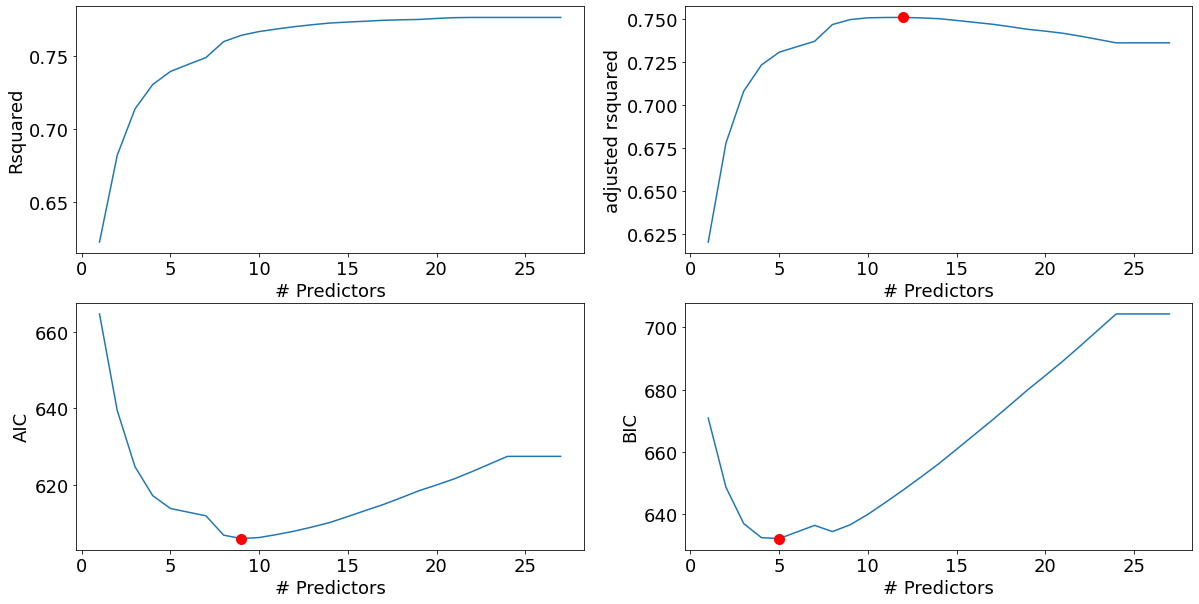

In [52]:
best_sub_plots()

In [53]:
# From BIC curve we should use 5 predictors
best_fwd_reg_model = models_best['model'][5]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     87.31
Date:                Fri, 24 Feb 2023   Prob (F-statistic):           3.75e-43
Time:                        00:41:27   Log-Likelihood:                -300.87
No. Observations:                 160   AIC:                             613.7
Df Residuals:                     154   BIC:                             632.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           7.4801      3.054      2.450      0.015       1.448      13.512
Rk                 -0.1193      0.045     -2.662      0.009      -0.208      -0.031
TOPerc             -0.2698      0.050     -5.409      0.000      -0.368      -0.171
Rush_Att            0.0138      0.003      4.828      0.000       0.008       0.019
YardsPerAttempt    -1.2258      0.340     -3.605      0.000      -1.898      -0.554
PF                  0.0134      0.006      2.292      0.023       0.002       0.025
==============================================================================
Omnibus:                        1.651   Durbin-Watson:                   1.688
Prob(Omnibus):                  0.438   Jarque-Bera (JB):                1.571
Skew:                          -0.241   Prob(JB):                        0.456
Kurtosis:                       2.941   Cond. No.                     1.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
train_data['W'] = (train_data['W'] >= 10).astype(int)
import statsmodels.formula.api as smf
logit_model = smf.logit(formula = 'W ~ PF + TOPerc + Rush_Yds + YardsPerAttempt + Rk', data = train_data).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.297865
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      W   No. Observations:                  160
Model:                          Logit   Df Residuals:                      154
Method:                           MLE   Df Model:                            5
Date:                Fri, 24 Feb 2023   Pseudo R-squ.:                  0.5399
Time:                        00:43:10   Log-Likelihood:                -47.658
converged:                       True   LL-Null:                       -103.59
Covariance Type:            nonrobust   LLR p-value:                 1.652e-22
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.9490      5.888      0.331      0.741      -9.591      13.489
PF                  0.0152      0.011      1.351      0.177      -0.007       0.037
TOPerc             -0.2799      0.108     -2.593      0.010      -0.491      -0.068
Rush_Yds            0.0033      0.001      2.545      0.011       0.001       0.006
YardsPerAttempt    -2.2756      1.007     -2.260      0.024      -4.249      -0.302
Rk                 -0.1414      0.088     -1.614      0.107      -0.313       0.030
===================================================================================
"""

In [58]:
# Get accuracy for training data
def confusion_matrix_train(model,cutoff=0.55):
    # Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(threshold = cutoff))
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))

Classification accuracy = 89.4%


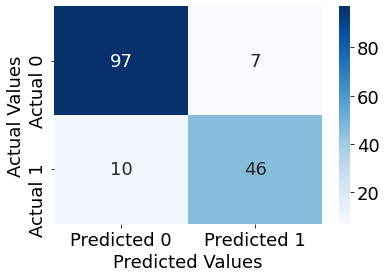

In [59]:
cm = confusion_matrix_train(logit_model)

In [60]:
def confusion_matrix_test(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))

Classification accuracy = 84.4%


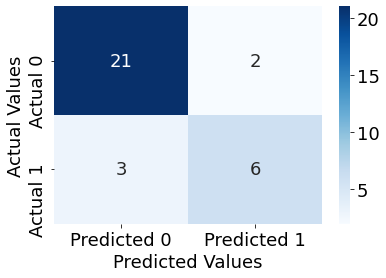

In [67]:
confusion_matrix_test(test_data, actual, logit_model, 0.55)